In [12]:
import meshio
import numpy as np
import dolfinx
from dolfinx import mesh, fem
from mpi4py import MPI
import ufl
import pyvista as pv
from dolfinx.io import XDMFFile

In [13]:
# Read STL file
input_stl = "test.stl"
mesh_data = meshio.read(input_stl)

# Save as an XDMF file (DOLFINx-compatible format)
xdmf_file = "converted_mesh.xdmf"
meshio.write(xdmf_file, mesh_data)

In [14]:
# Load mesh in DOLFINx
with XDMFFile(MPI.COMM_WORLD, xdmf_file, "r") as xdmf:
    domain_mesh = xdmf.read_mesh(name="Grid")

In [15]:
V = fem.functionspace(domain_mesh, ("CG", 1))  # First-order Lagrange elements

In [16]:
# Define boundary condition: u = 0 on all boundaries
u_bc = fem.Function(V)
u_bc.interpolate(lambda x: np.zeros_like(x[0]))
boundary_facets = mesh.locate_entities_boundary(domain_mesh, domain_mesh.topology.dim - 1, lambda x: np.full(x.shape[1], True))
bc = fem.dirichletbc(u_bc, fem.locate_dofs_topological(V, domain_mesh.topology.dim - 1, boundary_facets))

# Define source term: f = 1
f = fem.Constant(domain_mesh, 1.0)

In [17]:
# Define the variational problem
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [18]:
from dolfinx.fem.petsc import LinearProblem

problem = fem.petsc.LinearProblem(a, L, bcs=[bc])
u_sol = problem.solve()

In [19]:
from dolfinx.io import XDMFFile

# Save the solution to an XDMF file
with XDMFFile(MPI.COMM_WORLD, "solution.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain_mesh)
    xdmf.write_function(u_sol)

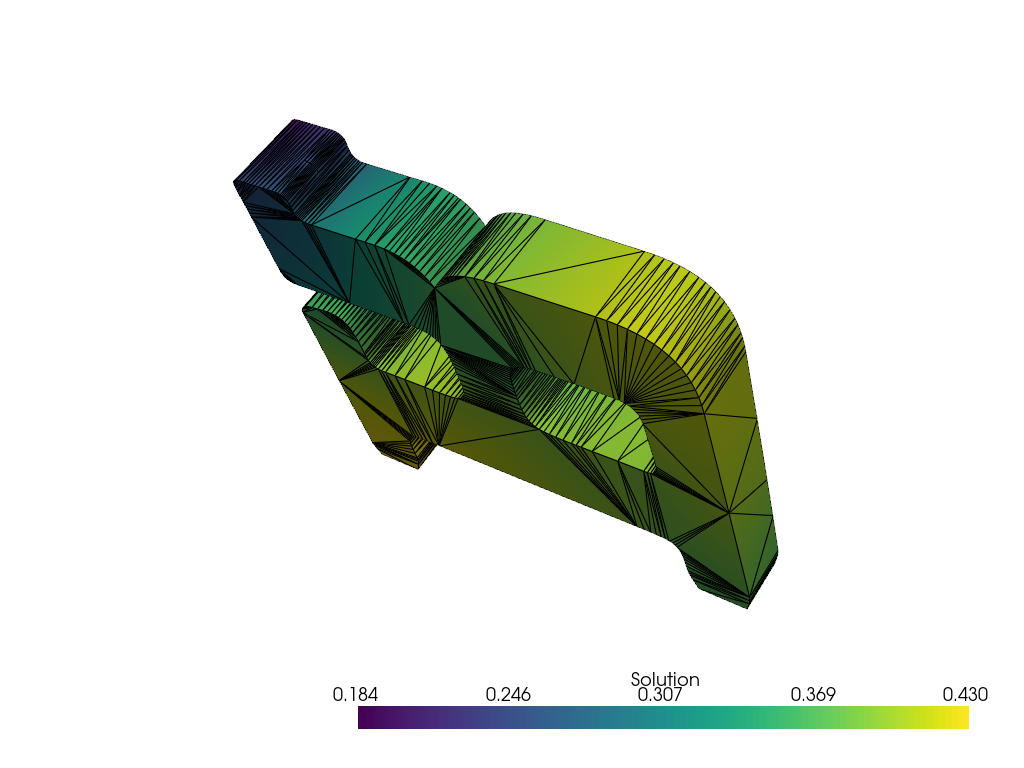

In [ ]:
import pyvista as pv
from dolfinx.plot import vtk_mesh

# Create a VTK mesh for visualization
topology, cell_types, geometry = vtk_mesh(domain_mesh)

# Create PyVista mesh
grid = pv.UnstructuredGrid(topology, cell_types, geometry)
grid["Solution"] = u_sol.x.array

# Plot solution
plotter = pv.Plotter()
plotter.add_mesh(grid, show_edges=True, scalars="Solution", cmap="viridis")
plotter.show()